In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Your work

## Q&A

### Basic Checks

In [4]:
# Check number of rows and columns 
print("The ATP dataframe has",df_atp.shape[0],"rows and",df_atp.shape[1],"columns")
print("The WTA dataframe has",df_wta.shape[0],"rows and",df_wta.shape[1],"columns")

The ATP dataframe has 52298 rows and 54 columns
The WTA dataframe has 29581 rows and 42 columns


In [5]:
# Examine the first 5 rows of ATP datframe
df_atp.head()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,UBW,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,NaN,63,Dosedel S.,2.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,NaN,5,Enqvist T.,2.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,7,6,NaN,NaN,NaN,40,Escude N.,2.0
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,NaN,65,Federer R.,2.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,7.0,5,6,NaN,NaN,NaN,81,Fromberg R.,2.0


In [6]:
# Examine the first 5 rows of WTA datframe
df_wta.head()

,AvgL,AvgW,B365L,B365W,Best of,CBL,CBW,Comment,Court,Date,...,UBL,UBW,W1,W2,W3,WPts,WRank,WTA,Winner,Wsets
0,NaN,NaN,3,1.33,3,2.90,1.38,Completed,Outdoor,2007-01-01,...,3.05,1.35,6.0,6.0,NaN,332.25,81.0,1,Sun T.T.,2.0
1,NaN,NaN,1.22,3.75,3,1.18,4.50,Completed,Outdoor,2007-01-01,...,1.25,3.75,6.0,6.0,6.0,401.75,59.0,1,Dulko G.,2.0
2,NaN,NaN,2,1.72,3,1.85,1.90,Completed,Outdoor,2007-01-01,...,NaN,NaN,6.0,6.0,NaN,418.50,56.0,1,Loit E.,2.0
3,NaN,NaN,1.83,1.83,3,1.66,2.15,Completed,Outdoor,2007-01-01,...,NaN,NaN,7.0,6.0,NaN,365.50,70.0,1,Craybas J.,2.0
4,NaN,NaN,4.5,1.16,3,4.85,1.16,Completed,Outdoor,2007-01-01,...,4.30,1.20,7.0,6.0,NaN,951.00,18.0,1,Bartoli M.,2.0


In [7]:
# Examine missing values in each column
df_atp.isna().sum()

ATP               0
AvgL          29553
AvgW          29553
B&WL          51201
B&WW          51201
B365L          8632
B365W          8655
Best of           0
CBL           34792
CBW           34792
Comment           0
Court             0
Date              0
EXL           12882
EXW           12887
GBL           47243
GBW           47243
IWL           38940
IWW           38940
L1              261
L2              771
L3            28130
L4            47567
L5            50507
LBL           24156
LBW           24167
LPts          16263
LRank            78
Location          0
Loser             0
Lsets           225
MaxL          29553
MaxW          29553
PSL           14959
PSW           14959
Round             0
SBL           46874
SBW           46874
SJL           36719
SJW           36726
Series            0
Surface           0
Tournament        0
UBL           41627
UBW           41627
W1              263
W2              772
W3            28129
W4            47567
W5            50507


In [8]:
# Explore datatypes of each feature
types = pd.DataFrame([df_atp.dtypes]).T.rename(columns = {0:"dtype"})
types[types['dtype'] == 'object']

,dtype
Comment,object
Court,object
EXW,object
L2,object
L3,object
LRank,object
Location,object
Loser,object
Lsets,object
Round,object


### 1- Who are the three ATP players with the most wins ?

In [9]:
# To answer this question we group the dataframe by winner name and check the number of rows
df_atp.groupby('Winner').count().sort_values(by='ATP', ascending = False).head(3)

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,UBL,UBW,W1,W2,W3,W4,W5,WPts,WRank,Wsets
Winner,,,,,,,,,,,,,,,,,,,,,
Federer R.,1121,478,478,30,30,1001,994,1121,445,445,...,269,269,1109,1103,537,91,29,788,1121,1112
Nadal R.,891,486,486,3,3,880,874,891,240,240,...,265,265,882,876,381,72,21,801,891,884
Djokovic N.,802,544,544,0,0,800,795,802,110,110,...,230,230,791,786,389,87,26,798,802,791


We can see the three ATP players with the most wins are Federer, Nadal and Djokovic.

### 2- How many sets did the player “​Federer R.” win in total ?

In [10]:
# We need to sum the number of sets won by Federer in matches he won and lost
# The Wsets columns represents the number of sets won by the winner, 
# and Lsets represents the number of sets won by the loser
# Looking at our basic EDA results above, the Lsets column is an object (instead of a float or int) 
# so we should examine it further, and find the values that are not integers
for a in df_atp['Lsets']:
    try:
        a + 1
    except:
        print(a)

`1


It appears that we only have one row where Lsets is a string, and appears to be a typo but to be sure lets look at the match score

In [11]:
df_atp[df_atp['Lsets'] == '`1'][['L1', 'L2', 'L3', 'L4', 'L5', 'W1', 'W2', 'W3', 'W4', 'W5']]

,L1,L2,L3,L4,L5,W1,W2,W3,W4,W5
18827,6.0,1,4,6.0,NaN,1.0,6,6,7.0,NaN


By looking at the match score we can conclude that the value of Lsets here should be 1.

In [12]:
# Change the value and the column type
df_atp.loc[18827, 'Lsets'] = 1.0
df_atp['Lsets'] = df_atp['Lsets'].astype('float64')

In [13]:
#Calculate number of sets won
print('The number of sets won by Roger Federer in total is', 
      df_atp[df_atp['Winner'] == 'Federer R.']['Wsets'].sum() + df_atp[df_atp['Loser'] == 'Federer R.']['Lsets'].sum())

The number of sets won by Roger Federer in total is 2696.0


### 3- How many sets did the player “​Federer R.” win during the years 2016 and 2017 ?

In [14]:
# Get dataframe with only matches set in 2016 and 2017
df_date = df_atp[(df_atp['Date'] >= '2016-01-01') & (df_atp['Date'] < '2018-01-01')]

# Calculate number of sets won as before
print('The number of sets won by Roger Federer during the years 2016 and 2017 is', 
      df_date[df_date['Winner'] == 'Federer R.']['Wsets'].sum() + df_date[df_date['Loser'] == 'Federer R.']['Lsets'].sum())

The number of sets won by Roger Federer during the years 2016 and 2017 is 182.0


### 4- For each match, what is the percentage of victories of the winner in the past ?

In [15]:
# Add a column that calculates percentage, as number of games won over total number of games played 

# First create function that takes player name and date and returns the percentage of games won
def percent_calc(Date, Player):
    df_prev = df_atp[df_atp['Date'] < Date]
    games_won = df_prev[df_prev['Winner'] == Player].shape[0]
    games_lost = df_prev[df_prev['Loser'] == Player].shape[0]
    games_total = games_won + games_lost
    if games_total == 0:
        return 0
    return (100.0*games_won)/games_total

# Create columns that show the percentage of wins for both players
df_atp['winner_percent_win'] = df_atp.apply(lambda row: percent_calc(row['Date'], row['Winner']), axis=1)
df_atp['loser_percent_win'] = df_atp.apply(lambda row: percent_calc(row['Date'], row['Loser']), axis=1)
df_atp.head()


,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,W2,W3,W4,W5,WPts,WRank,Winner,Wsets,winner_percent_win,loser_percent_win
0,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,6,NaN,NaN,NaN,NaN,63,Dosedel S.,2.0,0.0,0.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,6,NaN,NaN,NaN,NaN,5,Enqvist T.,2.0,0.0,0.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,7,6,NaN,NaN,NaN,40,Escude N.,2.0,0.0,0.0
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,6,NaN,NaN,NaN,NaN,65,Federer R.,2.0,0.0,0.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,5,6,NaN,NaN,NaN,81,Fromberg R.,2.0,0.0,0.0


## EDA

Now we explore the dataset a little more in depth.

### Datatypes

First we should look at the datatypes of the columns (above)

Some columns that we would expect to be integers or floats but are objects include: EXW, L2, L3, LRank, W2, W3, and WRank. We would definitely use LRank and WRank as features to predict the outcome.

In [16]:
# Look at non integer values of EXW 
print('EXW non integer values: ')
for a in df_atp['EXW']:
    try:
        a + 1
    except:
        print(a)

EXW non integer values: 
2.,3


As this is an obvious typo, we replace with 2.3

In [17]:
df_atp['EXW'] = df_atp['EXW'].apply(lambda x: 2.3 if x=='2.,3' else x)
df_atp['EXW'] = df_atp['EXW'].astype('float64')

In [18]:
# Look at non integer values of Ranking columns
print('LRank non integer values: ')
for a in df_atp['LRank']:
    try:
        a + 1
    except:
        print(a)

print('WRank non integer values: ')
for a in df_atp['WRank']:
    try:
        a + 1
    except:
        print(a)  

LRank non integer values: 
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
NR
WRank non integer values: 
NR


We have a few observations where we don't have a ranking available for the player. 
A non ranked player is usually ranked the lowest (Highest value).
Values of 'NR' will be treated as nulls, so in the interest of having a column with all integer values we replace them with NULLs.

In [19]:
# Replace values of NR with NULL in both columns
df_atp['WRank'] = df_atp['WRank'].apply(lambda x: None if x=='NR' else x)
df_atp['LRank'] = df_atp['LRank'].apply(lambda x: None if x=='NR' else x)
df_atp['WRank'] = df_atp['WRank'].astype('float64')
df_atp['LRank'] = df_atp['LRank'].astype('float64')

### Betting data

In [20]:
# Create dataframe for betting variables 
odds_columns = ['B365W', 'B365L', 'B&WW', 'B&WL', 
                'CBW', 'CBL', 'EXW', 'EXL', 
                'LBW', 'LBL', 'GBW', 'GBL', 
                'IWW', 'IWL', 'PSW', 'PSL', 
                'SBW', 'SBL', 'SJW', 'SJL', 
                'UBW', 'UBL', 'MaxW', 'MaxL', 
                'AvgW', 'AvgL']

df_odds = df_atp[odds_columns]

In [21]:
# Look at some statistics
df_odds.describe().T.sort_values(by='min')

,count,mean,std,min,25%,50%,75%,max
EXW,39411.0,1.802502,0.959033,0.000,1.250,1.500,2.050,20.00
SBL,5424.0,2.672064,1.424672,0.000,1.670,2.250,3.000,13.00
SBW,5424.0,1.793035,0.751026,0.000,1.333,1.571,2.100,9.00
B365W,43643.0,1.823768,1.100806,1.000,1.222,1.500,2.075,29.00
CBW,17506.0,1.812080,0.868254,1.000,1.280,1.550,2.050,14.00
EXL,39416.0,3.262180,2.449627,1.000,1.750,2.460,3.750,40.00
LBW,28131.0,1.810226,1.031691,1.000,1.250,1.500,2.000,26.00
LBL,28142.0,3.451461,3.075889,1.000,1.730,2.500,4.000,51.00
SJW,15572.0,1.796538,1.004273,1.000,1.220,1.500,2.000,19.00
PSW,37339.0,1.926742,1.334797,1.000,1.270,1.550,2.140,46.00


For some columns, we have the minimum as 0. This value doesn't make sense, as the odds are at least 1. 
Odds here represent the return on your money if your player wins, so it makes no sense to receive 0 * your bet.

Another value that is worth looking at is for MaxL, with a max value of 42586

In [22]:
# Show rows with odds < 1
df_odds[(df_odds['SBL'] < 1) | (df_odds['EXW'] < 1) | (df_odds['SBW'] < 1)]

,B365W,B365L,B&WW,B&WL,CBW,CBL,EXW,EXL,LBW,LBL,...,SBW,SBL,SJW,SJL,UBW,UBL,MaxW,MaxL,AvgW,AvgL
5912,NaN,NaN,NaN,NaN,1.60,2.25,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14655,1.8,1.9,NaN,NaN,1.85,1.92,0.0,1.87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since this happens in only 2 occurences, a safe number to impute those values with is 1.0, basically meaning that the player has a 50% chance of winning.


In [23]:
# Replace the values
df_atp['SBL'] = df_atp['SBL'].apply(lambda x: 1.0 if x == 0 else x)
df_atp['SBW'] = df_atp['SBW'].apply(lambda x: 1.0 if x == 0 else x)
df_atp['EXW'] = df_atp['EXW'].apply(lambda x: 1.0 if x == 0 else x)

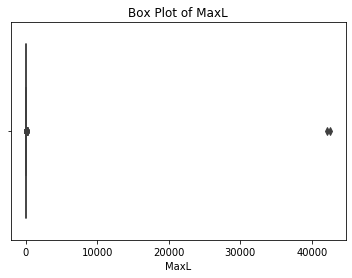

In [24]:
# Let us look at MaxL and plot boxplot
sns.boxplot(x = 'MaxL', data = df_atp[['MaxL']])
plt.title("Box Plot of MaxL");

We can see the outliers are extremely far to the right

In [25]:
# Look at the rows with these values
df_atp[df_atp['MaxL'] > 5000][['Date', 'Winner', 'Loser', 'Tournament', 'MaxL']]

,Date,Winner,Loser,Tournament,MaxL
43332,2015-06-30,Nadal R.,Bellucci T.,Wimbledon,42136.0
46527,2016-08-30,Thiem D.,Millman J.,US Open,42586.0


In [26]:
# It was very easy to find the actual values on oddsportal.com 
# Source: https://www.oddsportal.com/tennis/united-kingdom/atp-wimbledon-2015/bellucci-thomaz-nadal-rafael-Yy5iMIS2/#home-away;2

df_atp.loc[df_atp['MaxL'] == 42136, 'MaxL'] = 13.0
df_atp.loc[df_atp['MaxL'] == 42586, 'MaxL'] = 5.25

### Missing Values

In [27]:
# First drop all rows where all variables are nulls if there are any
df_atp = df_atp.dropna(axis=0, how='all')

In [28]:
# Let's look at the number and percentage of null values in each column
null_counter = pd.DataFrame({'null count': df_atp.isnull().sum().sort_values(ascending=False), 
                             'percent null': 100.0 * df_atp.isnull().sum().sort_values(ascending=False)/ df_atp.shape[0]},
                            index = df_atp.isnull().sum().sort_values(ascending=False).index)

null_counter[null_counter['null count']>0]

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,null count,percent null
B&WL,51201,97.902405
B&WW,51201,97.902405
L5,50507,96.575395
W5,50507,96.575395
L4,47567,90.953765
W4,47567,90.953765
GBL,47243,90.334238
GBW,47243,90.334238
SBL,46874,89.628666
SBW,46874,89.628666


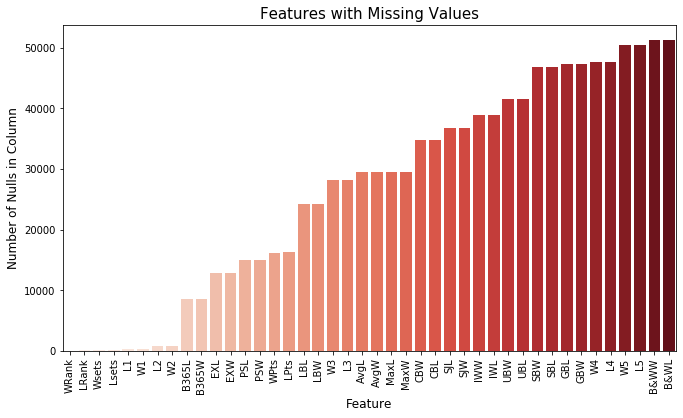

In [29]:
# Sort counts
missing = df_atp.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

# Plot this as a bar chart for each feature
plt.figure(figsize=(11,6))
sns.barplot(x = list(missing.index), y = list(missing.values), palette="Reds")
plt.title("Features with Missing Values", size=15)
plt.xlabel("Feature", size=12)
plt.ylabel("Number of Nulls in Column", size=12)
plt.xticks(rotation='vertical');

Looking at features with missing columns, we can separate them into 4 categories:
- Ranking columns
- Points columns 
- Odds columns
- Set resutls columns

We need to come up with strategies to impute values in those categories. 

#### 1- Rank Values

In [30]:
# Look at basic statistics
df_atp.describe()[['WRank', 'LRank']]

,WRank,LRank
count,52282.000000,52193.000000
mean,59.172564,92.227042
std,73.614866,116.947845
min,1.000000,1.000000
25%,17.000000,35.000000
50%,41.000000,65.000000
75%,77.000000,105.000000
max,1890.000000,2159.000000


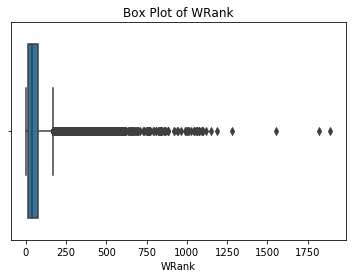

In [31]:
# Let us look at RankW and plot boxplot
sns.boxplot(x = 'WRank', data = df_atp[['WRank']])
plt.title("Box Plot of WRank");

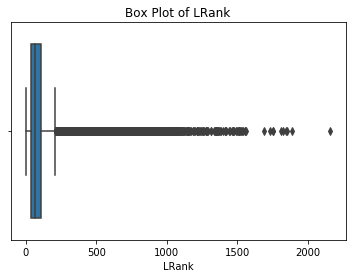

In [32]:
# Let us look at RankL and plot boxplot
sns.boxplot(x = 'LRank', data = df_atp[['LRank']])
plt.title("Box Plot of LRank");

The point columns represent the ATP Entry points of the player at the start of the tournament. 
Ranking of the players are based on their points, so it is worth looking at the relationship between those values.

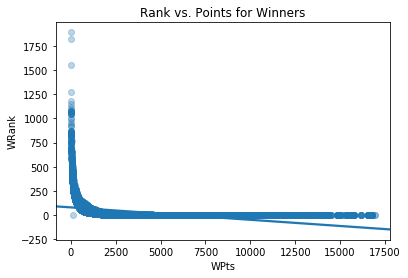

In [33]:
# Plot regplot
plt.figure(figsize=(6,4))
plt.title('Rank vs. Points for Winners')
sns.regplot(df_atp['WPts'], df_atp['WRank'], scatter_kws={'alpha':0.3});

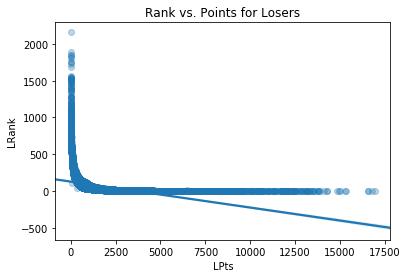

In [34]:
# Plot regplot
plt.figure(figsize=(6,4))
plt.title('Rank vs. Points for Losers')
sns.regplot(df_atp['LPts'], df_atp['LRank'], scatter_kws={'alpha':0.3});

From the regplots we have a clear relationship between Points and Ranks.

We can also look at the evolution of ranks overtime for specific players.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


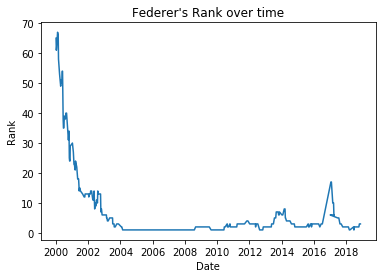

In [35]:
# Plot Roger Federer's ranking over time
df_federer = df_atp[(df_atp['Winner'] == 'Federer R.') | (df_atp['Loser'] == 'Federer R.')]
df_federer['frank'] = df_federer.apply(lambda x: x.WRank if x.Winner == 'Federer R.' else x.LRank, axis=1)

plt.title('Federer\'s Rank over time')
plt.ylabel('Rank')
plt.xlabel('Date')
plt.plot(df_federer['Date'], df_federer['frank']);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


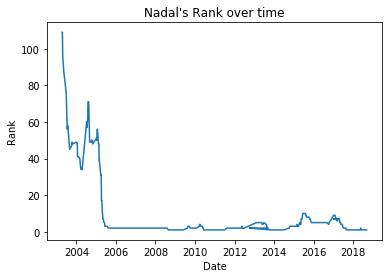

In [36]:
# Plot Rafael Nadal's ranking over time
df_nadal = df_atp[(df_atp['Winner'] == 'Nadal R.') | (df_atp['Loser'] == 'Nadal R.')]
df_nadal['nrank'] = df_nadal.apply(lambda x: x.WRank if x.Winner == 'Nadal R.' else x.LRank, axis=1)

plt.title('Nadal\'s Rank over time')
plt.ylabel('Rank')
plt.xlabel('Date')
plt.plot(df_nadal['Date'], df_nadal['nrank']);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


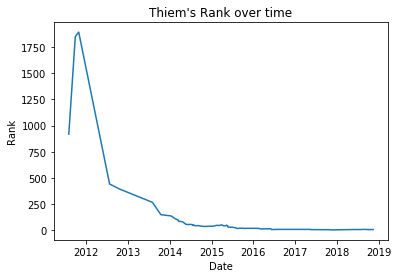

In [37]:
# Plot Dominic Thiem's ranking over time
df_thiem = df_atp[(df_atp['Winner'] == 'Thiem D.') | (df_atp['Loser'] == 'Thiem D.')]
df_thiem['trank'] = df_thiem.apply(lambda x: x.WRank if x.Winner == 'Thiem D.' else x.LRank, axis=1)

plt.title('Thiem\'s Rank over time')
plt.ylabel('Rank')
plt.xlabel('Date')
plt.plot(df_thiem['Date'], df_thiem['trank']);

In those 3 examples we can see that players start with a high-value rank at the begining of their careers, which could justify imputing with a large value for non-ranked players when the {WPts; LPts} values are missing.
A reasonable value would be the third quartile of each column (77 for WRank and 107 for LRank)

We can impute the values using regression based on points.

In [38]:
# Fit the model to available values of LPts and LRank
df_copy_l = df_atp.dropna(subset = ['LPts', 'LRank'])
df_copy_w = df_atp.dropna(subset = ['WPts', 'WRank'])

# Set up X and y
y_l = df_copy_l['LRank']
X_l = df_copy_l[['LPts']]
y_w = df_copy_w['WRank']
X_w = df_copy_w[['WPts']]

# Instanciate the model
lr_l = LinearRegression()
lr_w = LinearRegression()

# Fit the model
lr_l = lr_l.fit(X_l, y_l)
lr_w = lr_w.fit(X_w, y_w)

# First fill Ranks with 3rd quartile when Point value is blank
df_atp['LRank'] = np.where(df_atp['LPts'].isna(), 77, df_atp['LRank'])
df_atp['WRank'] = np.where(df_atp['WPts'].isna(), 105, df_atp['WRank'])

# Add column with predictions
df_atp['LRank_pred'] = pd.Series(lr_l.predict(X_l))
df_atp['WRank_pred'] = pd.Series(lr_w.predict(X_w))

# Force values to be greater than 1 
df_atp['LRank_pred'] = df_atp['LRank_pred'].apply(lambda x: max(1, x))
df_atp['WRank_pred'] = df_atp['WRank_pred'].apply(lambda x: max(1, x))

# Final columns with predictions instead of NULLs
df_atp['WRank'] = df_atp['WRank'].fillna(df_atp['WRank_pred'])
df_atp['LRank'] = df_atp['LRank'].fillna(df_atp['LRank_pred'])

In [39]:
# Make sure we don't have any NULLs left
df_atp[['WRank', 'LRank']].isna().sum()

WRank    0
LRank    0
dtype: int64

#### 2- Point Values

To get an understanding of points we should plot their values over time for specific players

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


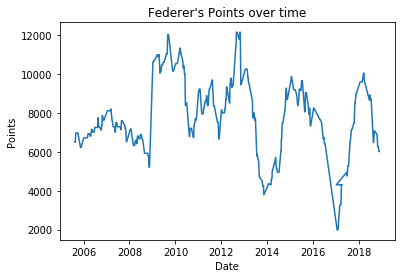

In [40]:
# Plot Roger Federer's points over time
df_federer['fpts'] = df_federer.apply(lambda x: x.WPts if x.Winner == 'Federer R.' else x.LPts, axis=1)

plt.title('Federer\'s Points over time')
plt.ylabel('Points')
plt.xlabel('Date')
plt.plot(df_federer['Date'], df_federer['fpts']);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


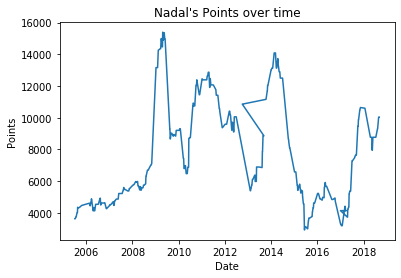

In [41]:
# Plot Nadal's points over time
df_nadal['npts'] = df_nadal.apply(lambda x: x.WPts if x.Winner == 'Nadal R.' else x.LPts, axis=1)

plt.title('Nadal\'s Points over time')
plt.ylabel('Points')
plt.xlabel('Date')
plt.plot(df_nadal['Date'], df_nadal['npts']);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


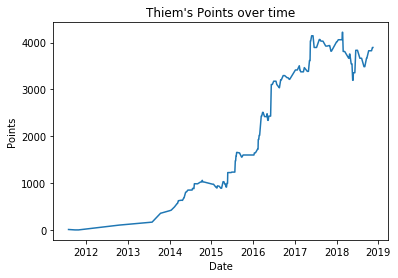

In [42]:
# Plot Thiem's points over time
df_thiem['tpts'] = df_thiem.apply(lambda x: x.WPts if x.Winner == 'Thiem D.' else x.LPts, axis=1)

plt.title('Thiem\'s Points over time')
plt.ylabel('Points')
plt.xlabel('Date')
plt.plot(df_thiem['Date'], df_thiem['tpts']);

We also already know that points and rankings are correlated, and so we can impute values using a regression this time by predicting points based on Ranks. 

In [43]:
# Fit the model to available values of LPts and WPts
df_copy_l = df_atp.dropna(subset = ['LPts'])
df_copy_w = df_atp.dropna(subset = ['WPts'])

# Set up X and y
y_l = df_copy_l['LPts']
X_l = df_copy_l[['LRank']]
y_w = df_copy_w['WPts']
X_w = df_copy_w[['WRank']]

# Instanciate the model
lr_l = LinearRegression()
lr_w = LinearRegression()

# Fit the model
lr_l = lr_l.fit(X_l, y_l)
lr_w = lr_w.fit(X_w, y_w)

# Add column with predictions
df_atp['LPts_pred'] = pd.Series(lr_l.predict(X_l))
df_atp['WPts_pred'] = pd.Series(lr_w.predict(X_w))

# Force values to be positive
df_atp['LPts_pred'] = df_atp['LPts_pred'].apply(lambda x: max(0, x))
df_atp['WPts_pred'] = df_atp['WPts_pred'].apply(lambda x: max(0, x))

# Final columns with predictions instead of NULLs
df_atp['WPts'] = df_atp['WPts'].fillna(df_atp['WPts_pred'])
df_atp['LPts'] = df_atp['LPts'].fillna(df_atp['LPts_pred'])

In [44]:
# Make sure we don't have any NULLs left
df_atp[['WPts', 'LPts']].isna().sum()

WPts    0
LPts    0
dtype: int64

#### 3- Odds Columns

- For AvgL, AvgW, MaxL and MaxM it makes sense to impute with the averages and maximum out of the available values.
- For remaining odds columns, strategies to consider could be imputing with:
    - the average of available odds for each player (by row), 
    - with the mean value for winning/losing odds (by column) (probem: will underestimate the variance of our variables),
    - we can randomly choose variables from a normal distribution with respective mean and std
    - give players a 50/50 chance (where we have no bet data, in around 3900 matches) and impute with a 1.0 for each player

In [45]:
# First fill NULLs in AvgL, AvgM, MaxL, MaxM
losing_odds = ['B365L', 'B&WL', 'CBL', 'EXL', 
               'LBL', 'GBL', 'IWL', 'PSL', 
               'SBL', 'SJL', 'UBL']
winning_odds = ['B365W', 'B&WW', 'CBW', 'EXW', 
               'LBW', 'GBW', 'IWW', 'PSW', 
               'SBW', 'SJW', 'UBW']
odds = ['B365W', 'B365L', 'B&WW', 'B&WL', 
        'CBW', 'CBL', 'EXW', 'EXL', 
        'LBW', 'LBL', 'GBW', 'GBL', 
        'IWW', 'IWL', 'PSW', 'PSL', 
        'SBW', 'SBL', 'SJW', 'SJL', 
        'UBW', 'UBL']


# Add columns
df_atp['Wmean'] = df_atp.apply(lambda x: x[winning_odds].mean(), axis =1)
df_atp['Lmean'] = df_atp.apply(lambda x: x[losing_odds].mean(), axis =1)
df_atp['Wmax'] = df_atp.apply(lambda x: x[winning_odds].max(), axis =1)
df_atp['Lmax'] = df_atp.apply(lambda x: x[losing_odds].max(), axis =1)

# Fill NULLs
df_atp['AvgW'] = df_atp['AvgW'].fillna(df_atp['Wmean'])
df_atp['AvgL'] = df_atp['AvgL'].fillna(df_atp['Lmean'])
df_atp['MaxW'] = df_atp['MaxW'].fillna(df_atp['Wmax'])
df_atp['MaxL'] = df_atp['MaxL'].fillna(df_atp['Wmax'])

# Fill NULLs in all columns with averages of available data
df_atp = df_atp.fillna({x: df_atp['Wmean'] for x in winning_odds})
df_atp = df_atp.fillna({x: df_atp['Lmean'] for x in losing_odds})

# Finally impute remaining missing values for games with no data with the mean
df_atp[odds_columns] = df_atp[odds_columns].fillna(df_atp[odds_columns].mean())

In [46]:
# Make sure we don't have any NULLs left
df_atp[odds_columns].isna().sum()

B365W    0
B365L    0
B&WW     0
B&WL     0
CBW      0
CBL      0
EXW      0
EXL      0
LBW      0
LBL      0
GBW      0
GBL      0
IWW      0
IWL      0
PSW      0
PSL      0
SBW      0
SBL      0
SJW      0
SJL      0
UBW      0
UBL      0
MaxW     0
MaxL     0
AvgW     0
AvgL     0
dtype: int64

#### Other notes:
- Missing values from {L1, L2, L3, W1, W2...} mean the set was not played.
- Missing values of total sets won by either winner or loser {Lsets, Wsets} always mean the game ended upon retirement or walkover, except for 1 occurence. The values can be recovered from {L1, L2, L3, W1, W2...}.

However the those are variables we wouldn't get before a game happens, therefore we wouldn't use as a feature

### Feature Engineering

We have nominal features here that can have an impact on our model, but we need to quantify them in order to be able to use them.

#### Surface

The surface affects players differently (for example, we know Nadal is particularly strong on Clay), and if we had a dataset for only one player it would make sense to quantify nominal surfaces by creating dummy columns, however we are not differenciating between player 1 and player 2, so we need to find a way to relate the meaning to each specific player.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<BarContainer object of 4 artists>

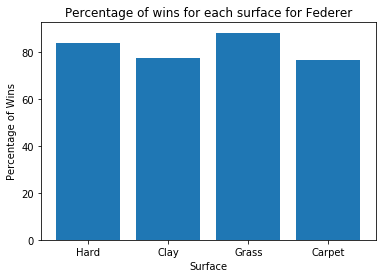

In [47]:
# Plot federer's win percentage on each surface
surfaces = list(df_atp['Surface'].unique())
federer_wins = []
for s in surfaces:
    temp = df_federer[df_atp['Surface'] == s]
    games_won = temp[temp['Winner'] == 'Federer R.'].shape[0]
    games_lost = temp[temp['Loser'] == 'Federer R.'].shape[0]
    games_total = games_won + games_lost
    federer_wins.append((100.0*games_won)/games_total)
    
# plot results
plt.title('Percentage of wins for each surface for Federer')
plt.ylabel('Percentage of Wins')
plt.xlabel('Surface')
plt.bar(x = surfaces, height=federer_wins)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<BarContainer object of 4 artists>

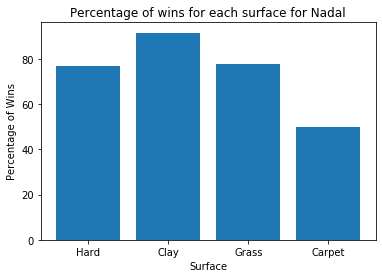

In [48]:
# Plot Nadal's win percentage on each surface
nadal_wins = []
for s in surfaces:
    temp = df_nadal[df_atp['Surface'] == s]
    games_won = temp[temp['Winner'] == 'Nadal R.'].shape[0]
    games_lost = temp[temp['Loser'] == 'Nadal R.'].shape[0]
    games_total = games_won + games_lost
    nadal_wins.append((100.0*games_won)/games_total)

# Plot results
plt.title('Percentage of wins for each surface for Nadal')
plt.ylabel('Percentage of Wins')
plt.xlabel('Surface')    
plt.bar(x = surfaces, height=nadal_wins)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


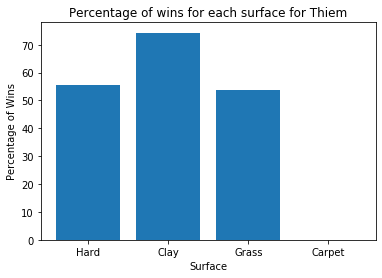

In [49]:
# Plot Thiem's win percentage on each surface
thiem_wins = []
for s in surfaces:
    temp = df_thiem[df_atp['Surface'] == s]
    games_won = temp[temp['Winner'] == 'Thiem D.'].shape[0]
    games_lost = temp[temp['Loser'] == 'Thiem D.'].shape[0]
    games_total = games_won + games_lost 
    if games_total ==0:
        thiem_wins.append(0)
    else:
        thiem_wins.append((100.0*games_won)/games_total)

# plot results
plt.title('Percentage of wins for each surface for Thiem')
plt.ylabel('Percentage of Wins')
plt.xlabel('Surface')
plt.bar(x = surfaces, height=thiem_wins);

In [50]:
# Define function that calculates percentage of previous games won by player on surface
def surface_percent_calc(Date, Surface, Player):
    df_prev_surface = df_atp[(df_atp['Date'] < Date) & (df_atp['Surface'] == Surface)]
    games_won = df_prev_surface[df_prev_surface['Winner'] == Player].shape[0]
    games_lost = df_prev_surface[df_prev_surface['Loser'] == Player].shape[0]
    games_total = games_won + games_lost
    if games_total == 0:
        return 0
    else: 
        return (100.0*games_won)/games_total

# Add columns
df_atp['winner_surface_percent'] = df_atp.apply(lambda x: surface_percent_calc(x.Date, x.Surface, x.Winner), axis=1)
df_atp['loser_surface_percent'] = df_atp.apply(lambda x: surface_percent_calc(x.Date, x.Surface, x.Loser), axis=1)

#### Target column

For our model, we should have an evenly distributed target (close to 50/50). We can consider that we are choosing between player 1 and player 2 to win the game, and our target column will have a value of 1 if player 1 won, and 0 if player 2 won.
For each game, we randomly choose who is player 1, and we expect that 50% of the time it will assign the winner

In [51]:
# Set up player 1 and 2 and target columns
df_atp['player_1'] = df_atp.apply(lambda x: np.random.choice([x['Winner'], x['Loser']]), axis = 1)
df_atp['player_2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['Loser'], x['Winner']), axis = 1)

df_atp['target'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], 1, 0), axis = 1)
df_atp['target'] = df_atp['target'].astype('float64')

df_atp['target'].value_counts()

0.0    26178
1.0    26120
Name: target, dtype: int64

As we can see we have about the same number of 1s and 0s in our target column.

We still need to reassign column values to match player 1 and 2 and not winner and losers, as those are the variables we used to get our target

In [52]:
p1_cols = ['Avgp1', 'B365p1', 'B&Wp1', 
           'CBp1', 'EXp1', 'LBp1', 'GBp1', 
           'IWp1', 'PSp1', 'SBp1', 'SJp1', 
           'UBp1', 'p1Rank', 'p1Pts', 
           'p1_percent_win', 'p1_surface_percent']

p2_cols = ['Avgp2', 'B365p2', 'B&Wp2', 
           'CBp2', 'EXp2', 'LBp2', 'GBp2', 
           'IWp2', 'PSp2', 'SBp2', 'SJp2', 
           'UBp2', 'p2Rank', 'p2Pts', 
           'p2_percent_win', 'p2_surface_percent']


df_atp['Avgp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['AvgW'], x['AvgL']), axis=1)
df_atp['B365p1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['B365W'], x['B365L']), axis=1)
df_atp['B&Wp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['B&WW'], x['B&WL']), axis=1)
df_atp['CBp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['CBW'], x['CBL']), axis=1)
df_atp['EXp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['EXW'], x['EXL']), axis=1)
df_atp['LBp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['LBW'], x['LBL']), axis=1)
df_atp['GBp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['GBW'], x['GBL']), axis=1)
df_atp['IWp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['IWW'], x['IWL']), axis=1)
df_atp['PSp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['PSW'], x['PSL']), axis=1)
df_atp['SBp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['SBW'], x['SBL']), axis=1)
df_atp['SJp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['SJW'], x['SJL']), axis=1)
df_atp['UBp1'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['UBW'], x['UBL']), axis=1)
df_atp['p1Rank'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['WRank'], x['LRank']), axis=1)
df_atp['p1Pts'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['WPts'], x['LPts']), axis=1)
df_atp['p1_percent_win'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['winner_percent_win'], x['loser_percent_win']), axis=1)
df_atp['p1_surface_percent'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_1'], x['winner_surface_percent'], x['loser_surface_percent']), axis=1)


df_atp['Avgp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['AvgW'], x['AvgL']), axis=1)
df_atp['B365p2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['B365W'], x['B365L']), axis=1)
df_atp['B&Wp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['B&WW'], x['B&WL']), axis=1)
df_atp['CBp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['CBW'], x['CBL']), axis=1)
df_atp['EXp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['EXW'], x['EXL']), axis=1)
df_atp['LBp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['LBW'], x['LBL']), axis=1)
df_atp['GBp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['GBW'], x['GBL']), axis=1)
df_atp['IWp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['IWW'], x['IWL']), axis=1)
df_atp['PSp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['PSW'], x['PSL']), axis=1)
df_atp['SBp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['SBW'], x['SBL']), axis=1)
df_atp['SJp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['SJW'], x['SJL']), axis=1)
df_atp['UBp2'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['UBW'], x['UBL']), axis=1)
df_atp['p2Rank'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['WRank'], x['LRank']), axis=1)
df_atp['p2Pts'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['WPts'], x['LPts']), axis=1)
df_atp['p2_percent_win'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['winner_percent_win'], x['loser_percent_win']), axis=1)
df_atp['p2_surface_percent'] = df_atp.apply(lambda x: np.where(x['Winner'] == x['player_2'], x['winner_surface_percent'], x['loser_surface_percent']), axis=1)

#### Dummy Variables

For other nominal variables, we quantify them by creating dummy variables.

The 'Best Of' column, while being of integer type, should be treated as a categorical value, as it corresponds to 2 types of games that can be played (either 2 sets to win or 3 sets to win), without necessarily meaning that 3 sets are 'greater than' 2 in the same sense that integer features have.

Date also cannot be treated as a numeric column, and should be treated as a dummy as well.

In [53]:
# Create year column
df_atp['Year'] = df_atp['Date'].apply(lambda x: x.year)

# Separate train and test datasets
df_train = df_atp[df_atp['Date'] < '2017-01-01']
df_test = df_atp[(df_atp['Date'] >= '2017-01-01') & (df_atp['Date'] <= '2017-12-31')]

# Get Nominal Features
nominal_columns = ['Year', 'Series', 'Round', 'Court', 'Best of']
train_nominals = df_train[nominal_columns]
test_nominals = df_test[nominal_columns]

# One-hot encode categorical variables:
train_dummies = pd.get_dummies(train_nominals, drop_first=True)
test_dummies = pd.get_dummies(test_nominals, drop_first=True)

We still need to make sure we have the same dummys in both tests for the model to run

In [54]:
# Print columns that are only in one of the sets
train_only_dummies = set(train_dummies.columns) - set(test_dummies.columns)
test_only_dummies  = set(test_dummies.columns) - set(train_dummies.columns)
print('Train only dummies ', train_only_dummies)
print('Test only dummies ', test_only_dummies)

Train only dummies  {'Series_International', 'Series_Masters', 'Series_International Gold'}
Test only dummies  set()


In [55]:
# We need to add columns to the test dummies (with value 0)
for train_dummy in train_only_dummies:
        test_dummies[train_dummy] = 0
        
# Maintain same column order between two dataframes
test_dummies = test_dummies[train_dummies.columns]

## Data Preparation

Now we should select the appropriate columns that will be used as features, which include:
- All numerical columns except: ATP, Best of, and all columns that are part of the results (Wx, Lx) 
- All nominal features encoded into dummies above

In [56]:
# Specify features
features = p1_cols + p2_cols

# Set up X and y
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train['target']
y_test = df_test['target']

# Merge with Dummy dataframe
X_train = pd.concat([X_train, train_dummies], axis =1)
X_test = pd.concat([X_test, test_dummies], axis =1)

## Modeling

### Baseline

In order to evaluate our model we need some benchmark value

In [57]:
# Find distribution of target
y_train.value_counts(normalize=True)

0.0    0.500978
1.0    0.499022
Name: target, dtype: float64

If we always predict that player 1 will win, then our model would have an accuracy of 0.504

We will be using accuracy scores to evaluate the models, as we dot not prefer one class over the other.

### Logistic Regression

In [58]:
# Instanciate model
lr = LogisticRegression()

# Fit the model
lr.fit(X_train, y_train)

# Generate predictions
y_pred = lr.predict(X_train)

# Print scores
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test, lr.predict(X_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy score: 0.7690099515182445
Test accuracy score: 0.6679316888045541


### Random Forest Classifier

First we instanciate a RFC model to find out the most relevant features

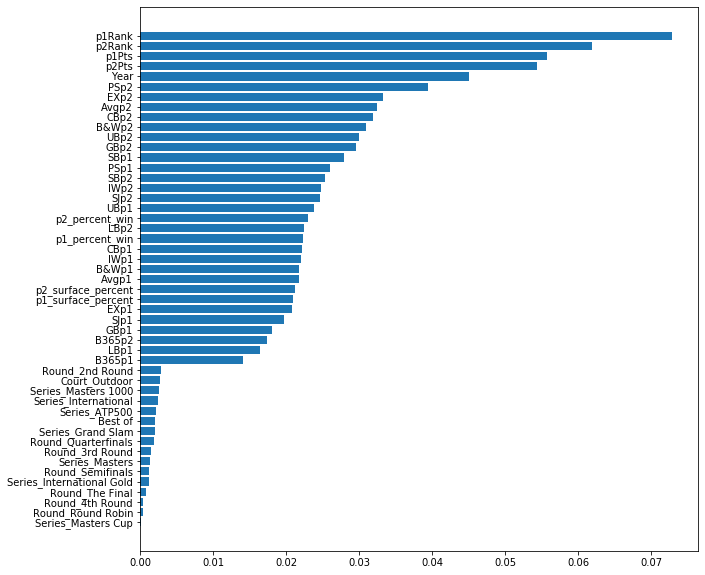

In [59]:
# Instanciate model
rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# Train the classifier
rf.fit(X_train, y_train)

# plot gini importance of each feature
feature_importance = rf.feature_importances_
cols = X_train.columns

df_features = pd.DataFrame({'feature': cols, 'feature_importance': feature_importance})
df_features = df_features.sort_values(by = 'feature_importance')

plt.figure(figsize=(10, 10))
plt.barh(y = df_features['feature'], width= df_features['feature_importance']);

In [60]:
# Select features that have an importance of more than 0.02
sfm = SelectFromModel(rf, threshold=0.02)

# Fit the model
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(df_features['feature'][feature_list_index])

Avgp1
B&Wp1
CBp1
EXp1
IWp1
PSp1
SBp1
UBp1
p1Rank
p1Pts
p1_percent_win
p1_surface_percent
Avgp2
B&Wp2
CBp2
EXp2
LBp2
GBp2
IWp2
PSp2
SBp2
SJp2
UBp2
p2Rank
p2Pts
p2_percent_win
p2_surface_percent
Year


In [61]:
# Create Dataset with important features

X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier
rf_important = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)

# fit the new classifier on the new dataset 
rf_important.fit(X_important_train, y_train)

# Generate predictions
y_important_pred = rf_important.predict(X_important_train)

# Print scores
print('train score: ', accuracy_score(y_train, y_important_pred))
print('test score: ', accuracy_score(y_test, rf_important.predict(X_important_test)))

train score:  1.0
test score:  0.6713472485768501


### Classifiers 

In [62]:
# Fit multiple classifiers on dataset with important features and see which one performs best 
names = ["Nearest Neighbors", "Decision Tree", 
         "Random Forest", 'Extra Trees', 
         "AdaBoost", 'Support Vector Machines']

classifiers = [ KNeighborsClassifier(5, n_jobs=-1), DecisionTreeClassifier(max_depth=10),
                RandomForestClassifier(max_depth=70, n_estimators=2000, n_jobs=5, min_samples_leaf=40, min_samples_split=80),
                ExtraTreesClassifier(max_depth=70, n_estimators=10, n_jobs=-1),
                AdaBoostClassifier(), SVC(C=0.5)]

train_accuracies = []
test_accuracies = []

for clf in classifiers:
    clf.fit(X_important_train, y_train)
    y_train_prediction = clf.predict(X_important_train)
    y_test_prediction = clf.predict(X_important_test)
    
    train_accuracies.append(accuracy_score(y_train, y_train_prediction))
    test_accuracies.append(accuracy_score(y_test, y_test_prediction))

results = pd.DataFrame({'Classifier': names, 'Train Accuracy': train_accuracies, 'Test Accuracy': test_accuracies})
results


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Classifier,Train Accuracy,Test Accuracy
0,Nearest Neighbors,0.833886,0.618975
1,Decision Tree,0.825381,0.673624
2,Random Forest,0.829442,0.682353
3,Extra Trees,1.000000,0.645541
4,AdaBoost,0.802968,0.677419
5,Support Vector Machines,0.522412,0.503226


### Random Forest

We now use GridSearch to tune hyperparameters for the most promising model

In [64]:
# Instanciate model
rf = RandomForestClassifier()

# Parameters tuning
rf_params = {
    'n_estimators': [2000, 2500],
    'max_depth': [50, 70],
    'max_features': [4, 6, 7],
    'min_samples_split': [20, 30]
}

# Find best parameters and scores
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_important_train, y_train)
print(gs.best_score_)
gs.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7665008080292591


{'max_depth': 50,
 'max_features': 4,
 'min_samples_split': 20,
 'n_estimators': 2000}

In [65]:
y_train_prediction = gs.predict(X_important_train)
y_test_prediction = gs.predict(X_important_test)
    
print(accuracy_score(y_train, y_train_prediction))
print(accuracy_score(y_test, y_test_prediction))

0.9382708173853874
0.6759013282732448
